<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stock_clustering_on_price_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/**

In [1]:
!pip install yfinance


     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 10.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [3]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
ticker['Symbol']=ticker['Symbol'].apply(lambda x:str(x)+'.ns')

In [4]:
companies_dict=dict(ticker[['Company Name','Symbol']].values)

In [5]:
companies = sorted(companies_dict.items(), key=lambda x: x[1])

In [6]:
# Define which online source to use
#data_source = 'yahoo'

# define start and end dates
start_date = '2017-01-01'

# Use pandas_datareader.data.DataReader to load the desired data list(companies_dict.values()) used for python 3 compatibility
panel_data = yf.download(list(companies_dict.values()),start_date)




[*********************100%***********************]  50 of 50 completed
[DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-17'],
              dtype='datetime64[ns]', name='Date', length=1247, freq=None), MultiIndex([('Adj Close', 'ADANIPORTS.NS'),
            ('Adj Close', 'ASIANPAINT.NS'),
            ('Adj Close',   'AXISBANK.NS'),
            ('Adj Close', 'BAJAJ-AUTO.NS'),
            ('Adj Close', 'BAJAJFINSV.NS'),
            ('Adj Close', 'BAJFINANCE.NS'),
            ('Adj Close', 'BHARTIARTL.NS'),
            ('Adj Close',       'BPCL.NS'),
            ('Adj Close',  'BRITANNIA.NS'),
            ('Adj Close',      'CIPLA.NS'),
            ...
      

In [ ]:
# Find Stock Open and Close Values
stock_close = panel_data['Close']
stock_open = panel_data['Open']



In [8]:
# Calculate daily stock movement
stock_close = np.array(stock_close).T
stock_open = np.array(stock_open).T

row, col = stock_close.shape

# create movements dataset filled with 0's
movements = np.zeros([row, col])

for i in range(0, row):
 movements[i,:] = np.subtract(stock_close[i,:], stock_open[i,:])

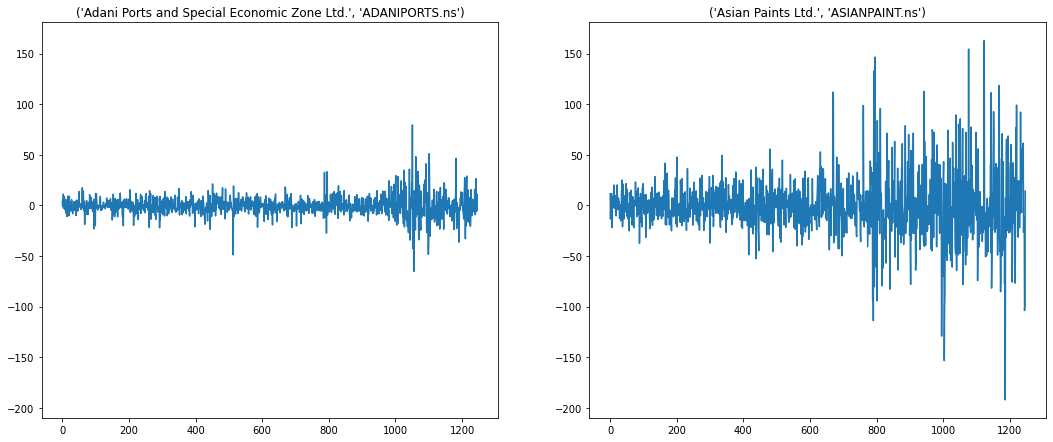

In [10]:
plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(movements[0][:])
plt.title(companies[0])

plt.subplot(222, sharey=ax1)
plt.plot(movements[1][:])
plt.title(companies[1])
plt.show()

In [11]:
np.isnan(movements).any()

True

In [12]:
movements[np.isnan(movements)] = np.median(movements[~np.isnan(movements)])

In [13]:
# import Normalizer
from sklearn.preprocessing import Normalizer
# create the Normalizer
normalizer = Normalizer()

new = normalizer.fit_transform(movements)

print(new.max())
print(new.min())
print(new.mean())

0.2400752563198705
-0.2862141554318234
-0.001561039948858838


In [14]:
# import machine learning libraries
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# define normalizer
normalizer = Normalizer()

# create a K-means model with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter=1000)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

In [15]:
# fit pipeline to daily stock movements
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(max_iter=1000, n_clusters=10))])

In [16]:
# predict cluster labels
labels = pipeline.predict(movements)

# create a DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# display df sorted by cluster labels
print(df.sort_values('labels'))

    labels                                          companies
35       0  (Power Grid Corporation of India Ltd., POWERGR...
33       0                               (NTPC Ltd., NTPC.ns)
1        1                 (Asian Paints Ltd., ASIANPAINT.ns)
21       1           (Hindustan Unilever Ltd., HINDUNILVR.ns)
32       1                  (Nestle India Ltd., NESTLEIND.ns)
8        1          (Britannia Industries Ltd., BRITANNIA.ns)
43       2                    (Tata Steel Ltd., TATASTEEL.ns)
20       2            (Hindalco Industries Ltd., HINDALCO.ns)
27       2                      (JSW Steel Ltd., JSWSTEEL.ns)
28       3           (Kotak Mahindra Bank Ltd., KOTAKBANK.ns)
5        3                (Bajaj Finance Ltd., BAJFINANCE.ns)
4        3                (Bajaj Finserv Ltd., BAJAJFINSV.ns)
29       3                      (Larsen & Toubro Ltd., LT.ns)
2        3                      (Axis Bank Ltd., AXISBANK.ns)
23       3                (IndusInd Bank Ltd., INDUSINDBK.ns)
38      

In [17]:
# PCA
from sklearn.decomposition import PCA 

# visualize the results
reduced_data = PCA(n_components = 2).fit_transform(new)

# run kmeans on reduced data
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
labels = kmeans.predict(reduced_data)

# create DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster labels
print(df.sort_values('labels'))

    labels                                          companies
29       0                      (Larsen & Toubro Ltd., LT.ns)
2        0                      (Axis Bank Ltd., AXISBANK.ns)
4        0                (Bajaj Finserv Ltd., BAJAJFINSV.ns)
5        0                (Bajaj Finance Ltd., BAJFINANCE.ns)
23       0                (IndusInd Bank Ltd., INDUSINDBK.ns)
22       0                    (ICICI Bank Ltd., ICICIBANK.ns)
38       0                     (State Bank of India, SBIN.ns)
9        1                             (Cipla Ltd., CIPLA.ns)
11       1            (Divi's Laboratories Ltd., DIVISLAB.ns)
12       1        (Dr. Reddy's Laboratories Ltd., DRREDDY.ns)
0        2  (Adani Ports and Special Economic Zone Ltd., A...
48       2                                 (UPL Ltd., UPL.ns)
7        2       (Bharat Petroleum Corporation Ltd., BPCL.ns)
14       2                (Grasim Industries Ltd., GRASIM.ns)
21       3           (Hindustan Unilever Ltd., HINDUNILVR.ns)
32      

In [44]:
lst=df[df['labels']==3]['companies'].tolist()

In [45]:
stocklst=[]
for i in lst:
   stocklst.append(str(i[1]))

In [46]:
data=yf.download(stocklst,'2018-01-01')['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [47]:
data['sum']=data.sum(axis=1)

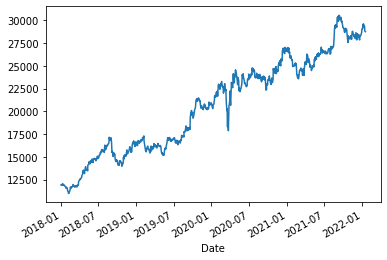

In [48]:
data['sum'].plot();